In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

from package import batch_gd, new_labels, report, convert_labels

# **GTSRB**

German Traffic Sign Recognition Benchmark: In this notebook, I'll train an image classification model using PyTorch. 

For this task I chose the GTSRB dataset provided by the torchvision lybrary.

https://pytorch.org/vision/stable/generated/torchvision.datasets.GTSRB.html#torchvision.datasets.GTSRB

## **Step 1: Exploratory Data Analysis**

TODO:
* Look up the classes
* Plot the distribution
* Fix eventual problems with the data

### **Downloading data** 

In [2]:
transforms = transforms.Compose([
        transforms.Resize([60,60]), # the image are not all equal in size, we need to define a standard size
        transforms.ToTensor() # converts images to torch Tensors and rescales pixels to [0;1] 
    ])

train_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='train',
    transform=transforms,
    download=True
)

test_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='test',
    transform=transforms,
    download=True
)

In [3]:
len(train_dataset)

26640

### **Data Loader**

In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

### **Visualization**

Image shape: torch.Size([128, 3, 60, 60]), label shape: torch.Size([128])
Min and max pixel values: [0.0, 1.0]
Number of classes 42


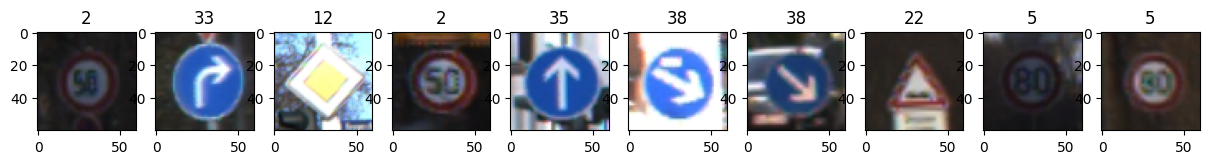

In [5]:
for x, y in train_loader:
    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')
    figure, axis = plt.subplots(1, 10, figsize=(15,15))
    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We can see from this first plot that the images are labeled with numbers from 0 to 42, meaning there 43 classes. In case this task is too hard, we can try to regroup some of the classes in more generic ones (speed limitation, danger, change of direction, ..)

Another thing to see is that images vary largely in contrast, sharpness and quality, it might not be useful to try to augment the data from the start as the difference between images is already really high.

<img src='https://miro.medium.com/max/1100/1*mWK70K4agwvlwR-JBiT-aw.webp' style="background-color:white" width="600" height="500" />

### **Data balancing**

In [9]:
# --- Long computation, commented for performance ---

# train_labels = np.array([]) 
# for x, y in train_loader:
#     train_labels = np.concatenate((train_labels, y))

# test_labels = np.array([]) 
# for x, y in test_loader:
#     test_labels = np.concatenate((test_labels, y))
    
# fig = px.histogram(train_labels, text_auto=True, title="Training samples distribution for the new classes")
# fig.show()

In [24]:
def plot_distrib(path:str, title:str):
    df = pd.read_csv(path, sep=',', index_col=0)
    fig = px.histogram(df.values, text_auto=True, title=title)
    fig.show()
plot_distrib(path='data/train_labels.csv', title="Training samples distribution")
plot_distrib(path='data/test_labels.csv', title="Testing samples distribution")

These two plots show that the data is well stratified between the train and test set (the class distribution is the same between train and test). 

Furthermore, there is some imbalance between classes, for example the class 0 (20 km/h speed limitation) has only 60 images where class 2 (50 km/h speed limitation) has 750. If this imbalance prevents the model from classifying minority classes, there are several techniques we can implement:
* augmenting the minority classes (changing colors, rotating, cropping, ...) to have more training data
* apply class weights to the model so that errors on minority classes matter more than errors on majority classes
* reduce the number of classes by creating more general ones

### **A way of creating new classes** 

In [ ]:
assert len(new_labels.keys()) == 43, "Some labels might not have been replaced"

In [ ]:
for x,y in train_loader:
    print(convert_labels(y))
    break

tensor([0, 6, 1, 2, 0, 5, 1, 0, 6, 2, 5, 0, 0, 0, 5, 2, 2, 0, 1, 4, 1, 5, 0, 5,
        1, 3, 2, 2, 5, 2, 4, 1, 1, 0, 5, 2, 2, 5, 1, 5, 0, 4, 1, 5, 4, 0, 0, 0,
        5, 4, 4, 2, 0, 0, 2, 0, 5, 0, 1, 0, 0, 4, 5, 3, 0, 5, 0, 1, 0, 0, 2, 1,
        5, 4, 1, 1, 5, 3, 0, 1, 0, 0, 1, 1, 0, 0, 5, 0, 1, 1, 1, 5, 2, 4, 5, 1,
        5, 0, 0, 0, 0, 5, 0, 4, 5, 0, 5, 0, 0, 0, 0, 5, 1, 5, 5, 4, 0, 2, 0, 0,
        1, 0, 5, 4, 0, 2, 0, 4])


In [ ]:
# --- Long computation, commented for performance ---

# full_train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=train_dataset.__len__(),
# )
# for x, y in full_train_loader:
#     original_labels = convert_labels(y)
# fig = px.histogram(original_labels.numpy(), text_auto=True, title="Training samples distribution for the new classes")
# fig.show()

<img src="images\training_distribution.png" />

This graph reveals a slight inbalance in the label distribution we created. The underrepresented classes are "End of limitation" and "Stop" as they refer to few different traffic signs. If the performances on these classes are underwhelming, we can apply class weights in order to bring some balance or use data augmentation to create new samples artificially.

For now, we will start with the original classes.

# **Step 2: Modeling**

We now have to design an architecture for our classifier. For this task I chose Convolutional Neural Networks, these types of model have been gaining in popularity since the publication of AlexNet in 2012 (it was not the first CNN but the first to achieve significant results on ImageNet).

These models use convolutional layers which means a kernel (or a filer, usually a square matrix of size 3, 5, 7, ..) will 'slide' along the image and apply convolutions. 

<img src="images/convolution.png" style="background-color:white" width="900" height="400" />

These convolutions will create __*feature maps*__ (outputs of the filters for a certain image). For different filters, different features of the image will appear on the feature maps (edges, straight lines, a particular shape or object), which will allow the subsequent classification.

Those feature maps will be fed to a usual ANN (a succession of dense layers).

To implement a CNN in PyTorch, we have to be aware of the size of the feature maps at each step of the convolutional part of the network. We can track this size using the following formula.

Output size of convolution and pooling layers :

*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride
*   D = dilation (always 1 here)

Convolution: $W_{out} = \left \lfloor \frac{W - F + 2P}{S} \right \rfloor +1$

In [9]:
def conv_arithmetic(input_size:list, kernel_size:list, padding:list, stride:list, type:str):
  """ 
  For type 'conv':
    Returns the output shape of an image after one iteration of "Zero padding, non-unit strides" convolution
    reference: https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html
  For type 'max_pooling':
    Returns the output shape of an image after one ieration of max pooling (2d)
    reference: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
  """
  assert type in ['conv', 'max_pooling'], "invalid type"
  
  if type == 'conv':
      return np.floor(np.divide(input_size + 2*padding[0] - kernel_size[0], stride[0])) + 1
  elif type == 'max_pooling':
      return np.floor(np.divide(input_size +2*padding[1] -1*(kernel_size[1]-1) -1, stride[1]) +1)


def compute_shapes(img_size:int, seq:list):
  for it in range(len(seq)):
    img_size = conv_arithmetic(img_size, kernel_size=[3,2], padding=[1,1], stride=[2,2], type=seq[it])
    print(f'  {it}: {seq[it]} => image size: {img_size}')
  return img_size

In [11]:
print('Simple CNN:')
compute_shapes(img_size=60, seq=['conv','conv','conv','conv'])

Simple CNN:
  0: conv => image size: 30.0
  1: conv => image size: 15.0
  2: conv => image size: 8.0
  3: conv => image size: 4.0


4.0

For now, we will start with a simple model acting as a baseline. This CNN will be composed of 4 convolutional layers and 3 dense layers.

In [44]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.Conv2d(256, 512, 3, 2, 1),
        )

        self.Dense = nn.Sequential(
            nn.Linear(512*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, K)
        )

    def forward(self, x):
        x = self.convolutions(x)
        flat = x.view(x.shape[0], -1)
        x = self.Dense(flat)
        return x

Now we instantiate the model and define the loss function and optimizer.
* The cross entropy loss is appropriate for a classification problem 
* Adam is a standard choice for an optimize

In [45]:
model = CNN(43)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In order to make the computation faster, we move the model to the GPU, we will eventually do the same for each training batch

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [48]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, 10)

Epoch 1 / 10: Train Loss : 1.4597, Test Loss : 1.0646, duration: 0:00:25.213826
Epoch 2 / 10: Train Loss : 0.3229, Test Loss : 0.9218, duration: 0:00:18.179343
Epoch 3 / 10: Train Loss : 0.1834, Test Loss : 1.0171, duration: 0:00:18.304088
Epoch 4 / 10: Train Loss : 0.1587, Test Loss : 1.0822, duration: 0:00:17.649664
Epoch 5 / 10: Train Loss : 0.1363, Test Loss : 1.1147, duration: 0:00:17.615987
Epoch 6 / 10: Train Loss : 0.1191, Test Loss : 1.4134, duration: 0:00:17.582081
Epoch 7 / 10: Train Loss : 0.1181, Test Loss : 1.2470, duration: 0:00:17.459329
Epoch 8 / 10: Train Loss : 0.1109, Test Loss : 1.3101, duration: 0:00:17.854763
Epoch 9 / 10: Train Loss : 0.1009, Test Loss : 1.3478, duration: 0:00:17.721821
Epoch 10 / 10: Train Loss : 0.1356, Test Loss : 1.5574, duration: 0:00:17.566943


Here we can clearly see that the model is overfitting (this is a sign of low bias and high variance).

In a next step, we could try to add layers to this simple model to help reduce overfitting.

              precision    recall  f1-score   support

         0.0       0.77      0.45      0.57        60
         1.0       0.78      0.91      0.84       720
         2.0       0.78      0.94      0.85       750
         3.0       0.88      0.58      0.70       450
         4.0       0.88      0.84      0.86       660
         5.0       0.60      0.77      0.67       630
         6.0       0.99      0.65      0.79       150
         7.0       0.86      0.72      0.78       450
         8.0       0.82      0.84      0.83       450
         9.0       0.94      0.91      0.92       480
        10.0       0.95      0.92      0.94       660
        11.0       0.70      0.92      0.80       420
        12.0       0.99      0.90      0.94       690
        13.0       0.98      0.94      0.96       720
        14.0       0.99      0.99      0.99       270
        15.0       0.80      0.84      0.82       210
        16.0       0.98      0.96      0.97       150
        17.0       0.98    

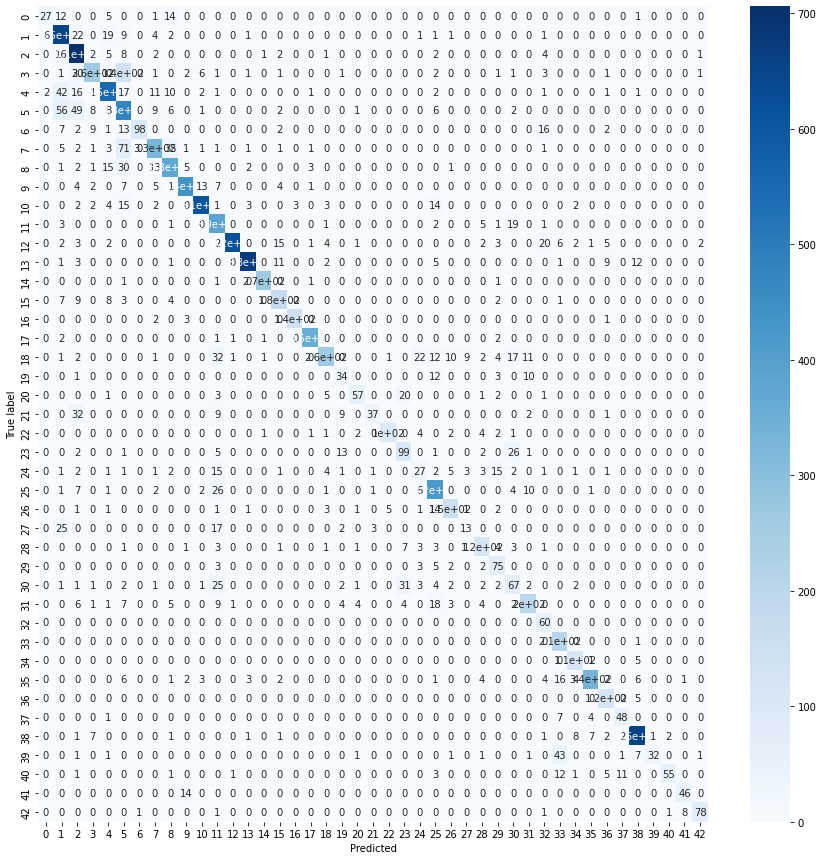

In [50]:
X_test, p_test, y_test = report(model,test_loader, device, train_losses, test_losses)